In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.regularizers import l1,l2
from keras import backend as K
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, hsv2rgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true # K.flatten(y_true)
    y_pred_f = y_pred # K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [3]:
# load the dataset
(xtrain, _), (xtest, _) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.

xtrain_red = xtrain[:,:,:,0]
xtrain_green = xtrain[:,:,:,1] 
xtrain_blue = xtrain[:,:,:,2]

xtest_red = xtest[:,:,:,0]
xtest_green = xtest[:,:,:,1] 
xtest_blue = xtest[:,:,:,2]

xtrain_red = xtrain_red.reshape(len(xtrain_red), np.prod(xtrain_red.shape[1:]))
xtrain_green = xtrain_green.reshape(len(xtrain_green), np.prod(xtrain_green.shape[1:]))
xtrain_blue = xtrain_blue.reshape(len(xtrain_blue), np.prod(xtrain_blue.shape[1:]))

xtest_red = xtest_red.reshape(len(xtest_red), np.prod(xtest_red.shape[1:]))
xtest_green = xtest_green.reshape(len(xtest_green), np.prod(xtest_green.shape[1:]))
xtest_blue = xtest_blue.reshape(len(xtest_blue), np.prod(xtest_blue.shape[1:]))

In [5]:
input_layer = xtrain_red.shape[1]
hid_layer1 = 576
hid_layer2 = 256
hid_layer3 = 64
hid_layer4 = 10
hid_layer5 = hid_layer3
hid_layer6 = hid_layer2
hid_layer7 = hid_layer1
output_layer = input_layer
print(xtrain_red.shape)
print(xtest_red.shape)

(50000, 1024)
(10000, 1024)


In [6]:
input_img_red = Input(shape=(input_layer,))
input_img_green = Input(shape=(input_layer,))
input_img_blue = Input(shape=(input_layer,))

W0818 13:33:14.621620 140625008568192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 13:33:14.657584 140625008568192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [7]:
# network architecture
# vanilla autoencoder with fully-connected layer
# RED
x = Dense(units = hid_layer1, activation='relu')(input_img_red)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer2, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer3, activation='relu')(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer1, activation='relu')(input_img_green)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer2, activation='relu')(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer3, activation='relu')(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer1, activation='relu')(input_img_blue)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer2, activation='relu')(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer3, activation='relu')(z)
# z = BatchNormalization()(z)

encoded_red = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(x)
encoded_green = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(y)
encoded_blue = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(z)

# RED
x = Dense(units = hid_layer5, activation = 'relu')(encoded_red)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer6, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer7, activation='relu')(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer5, activation = 'relu')(encoded_green)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer6, activation='relu')(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer7, activation='relu')(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer5, activation = 'relu')(encoded_blue)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer6, activation='relu')(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer7, activation='relu')(z)
# z = BatchNormalization()(z)

decoded_red = Dense(units = output_layer, activation='sigmoid')(x)
decoded_green = Dense(units = output_layer, activation='sigmoid')(y)
decoded_blue = Dense(units = output_layer, activation='sigmoid')(z)

autoencoder_red = Model(input_img_red, decoded_red)
autoencoder_green = Model(input_img_green, decoded_green)
autoencoder_blue = Model(input_img_blue, decoded_blue)

encoder_red = Model(input_img_red, encoded_red)
encoder_green = Model(input_img_green, encoded_green)
encoder_blue = Model(input_img_blue, encoded_blue)

autoencoder_red.compile(optimizer= Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
autoencoder_green.compile(optimizer= Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
autoencoder_blue.compile(optimizer= Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

W0818 13:33:14.726444 140625008568192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 13:33:15.117237 140625008568192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
# train the model
history_red = autoencoder_red.fit(xtrain_red, xtrain_red,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(xtest_red, xtest_red))

W0818 13:33:15.441465 140625008568192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0818 13:33:15.684705 140625008568192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 168us/step - loss: 0.4146 - dice_coef: 0.5859 - val_loss: 0.3413 - val_dice_coef: 0.6592
Epoch 2/100
50000/50000 [==============================] - 4s 84us/step - loss: 0.3420 - dice_coef: 0.6585 - val_loss: 0.3389 - val_dice_coef: 0.6616
Epoch 3/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3413 - dice_coef: 0.6592 - val_loss: 0.3387 - val_dice_coef: 0.6618
Epoch 4/100
50000/50000 [==============================] - 4s 84us/step - loss: 0.3408 - dice_coef: 0.6596 - val_loss: 0.3380 - val_dice_coef: 0.6624
Epoch 5/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3400 - dice_coef: 0.6604 - val_loss: 0.3368 - val_dice_coef: 0.6636
Epoch 6/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3361 - dice_coef: 0.6643 - val_loss: 0.3318 - val_dice_coef: 0.6686
Epoch 7/100
50000/50000 [========================

In [9]:
# train the model
history_green = autoencoder_green.fit(xtrain_green, xtrain_green,
                                epochs=100,
                                batch_size=128,
                                shuffle=True,
                                validation_data=(xtest_green, xtest_green))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.4182 - dice_coef: 0.5823 - val_loss: 0.3512 - val_dice_coef: 0.6493
Epoch 2/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3513 - dice_coef: 0.6491 - val_loss: 0.3480 - val_dice_coef: 0.6524
Epoch 3/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3505 - dice_coef: 0.6499 - val_loss: 0.3476 - val_dice_coef: 0.6528
Epoch 4/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3499 - dice_coef: 0.6505 - val_loss: 0.3469 - val_dice_coef: 0.6535
Epoch 5/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3490 - dice_coef: 0.6515 - val_loss: 0.3455 - val_dice_coef: 0.6549
Epoch 6/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3452 - dice_coef: 0.6552 - val_loss: 0.3412 - val_dice_coef: 0.6592
Epoch 7/100
50000/50000 [=========================

In [10]:
# train the model
history_blue = autoencoder_blue.fit(xtrain_blue, xtrain_blue,
                                epochs=100,
                                batch_size=128,
                                shuffle=True,
                                validation_data=(xtest_blue, xtest_blue))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.4425 - dice_coef: 0.5580 - val_loss: 0.3796 - val_dice_coef: 0.6209
Epoch 2/100
50000/50000 [==============================] - 4s 82us/step - loss: 0.3821 - dice_coef: 0.6184 - val_loss: 0.3782 - val_dice_coef: 0.6223
Epoch 3/100
50000/50000 [==============================] - 4s 82us/step - loss: 0.3810 - dice_coef: 0.6195 - val_loss: 0.3768 - val_dice_coef: 0.6237
Epoch 4/100
50000/50000 [==============================] - 4s 82us/step - loss: 0.3783 - dice_coef: 0.6222 - val_loss: 0.3720 - val_dice_coef: 0.6285
Epoch 5/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.3739 - dice_coef: 0.6266 - val_loss: 0.3699 - val_dice_coef: 0.6306
Epoch 6/100
50000/50000 [==============================] - 4s 82us/step - loss: 0.3728 - dice_coef: 0.6277 - val_loss: 0.3692 - val_dice_coef: 0.6313
Epoch 7/100
50000/50000 [=========================

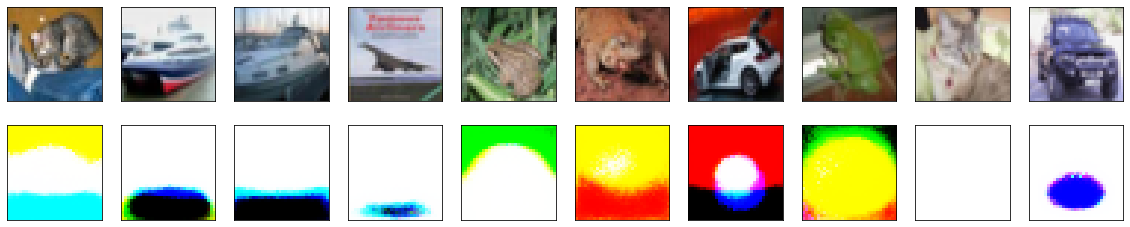

In [11]:
# show the result at the decoder output
decoded_imgs_red = autoencoder_red.predict(xtest_red)
decoded_imgs_green = autoencoder_green.predict(xtest_green)
decoded_imgs_blue = autoencoder_blue.predict(xtest_blue)

counter = 0
n = 10
test_imgs = np.zeros((32,32,3))
dec_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[counter + i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[counter + i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[counter + i].reshape(32, 32)

    plt.imshow(test_imgs)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    dec_imgs[:,:,0] = decoded_imgs_red[counter + i].reshape(32, 32)
    dec_imgs[:,:,1] = decoded_imgs_green[counter + i].reshape(32, 32)
    dec_imgs[:,:,2] = decoded_imgs_blue[counter + i].reshape(32, 32)

    plt.imshow(dec_imgs)
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

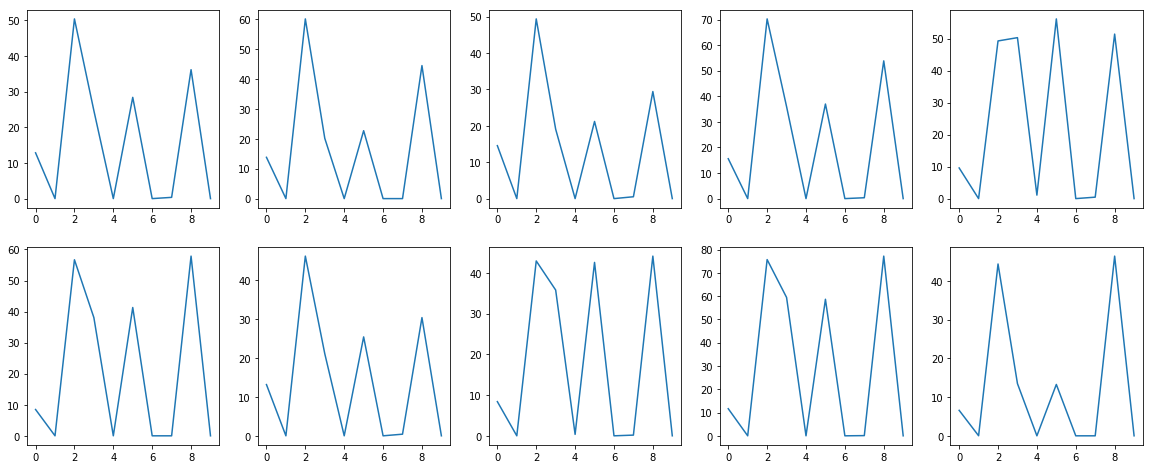

In [12]:
# show the representation at the bottleneck
encoded_imgs_red = encoder_red.predict(xtest_red)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_red[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

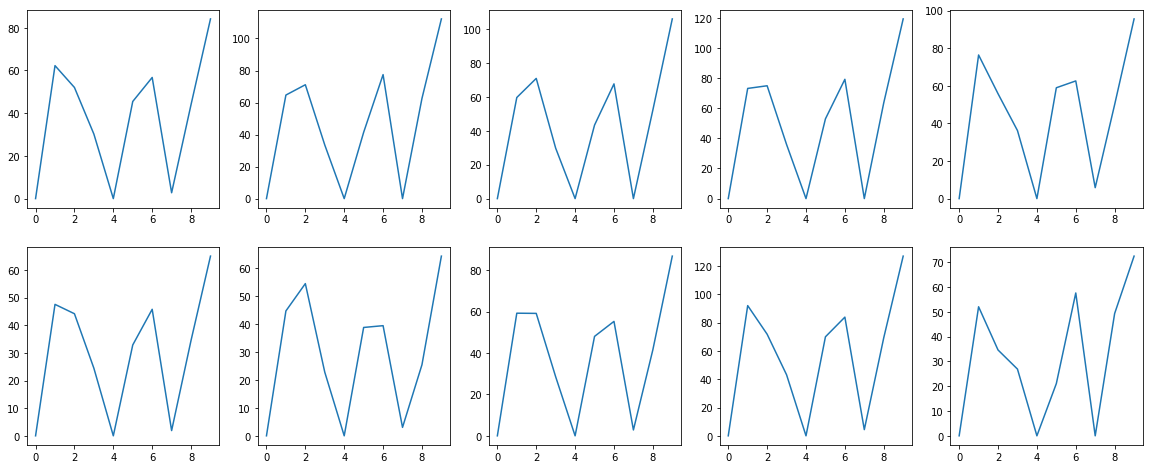

In [13]:
# show the representation at the bottleneck
encoded_imgs_green = encoder_green.predict(xtest_green)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_green[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

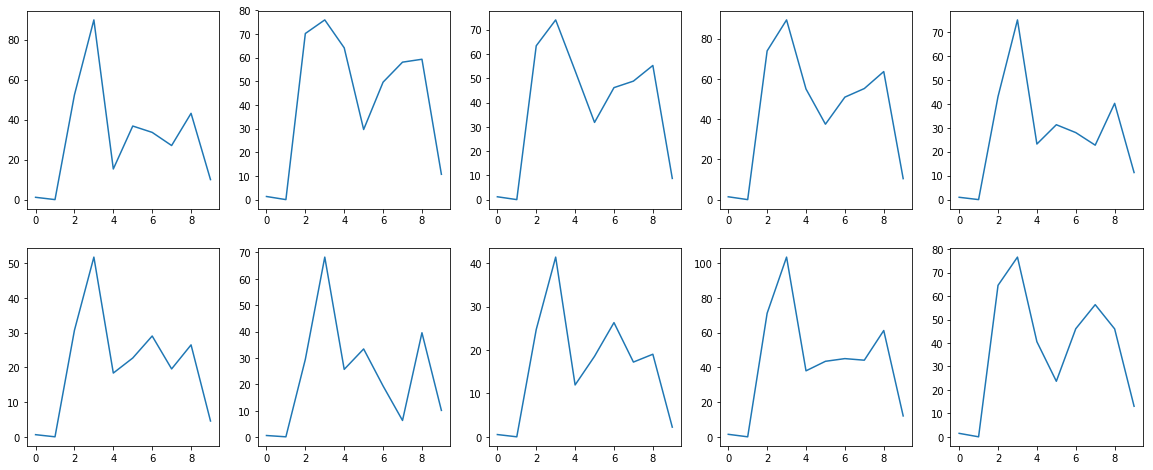

In [14]:
# show the representation at the bottleneck
encoded_imgs_blue = encoder_blue.predict(xtest_blue)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs_blue[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

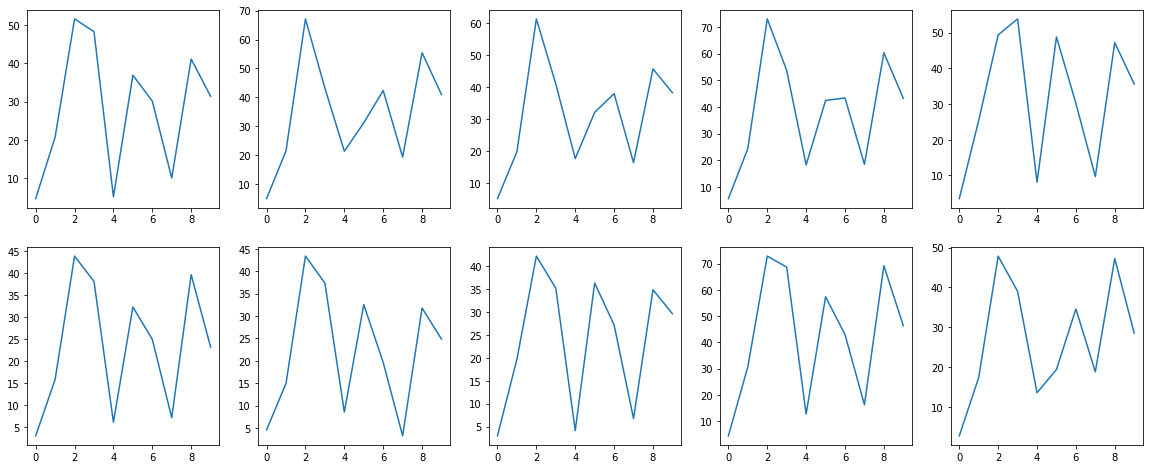

In [15]:
sum_encoded = (encoded_imgs_red + encoded_imgs_green + encoded_imgs_blue)/3.

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(sum_encoded[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

In [0]:
autoencoder_red.save('autoencoder_baseline_red_dice.h5')
autoencoder_green.save('autoencoder_baseline_green_dice.h5')
autoencoder_blue.save('autoencoder_baseline_blue_dice.h5')

(array([367., 161., 104.,  70., 126.,  97.,  50.,  22.,  15.,  12.]),
 array([5.9604645e-08, 9.8822385e-02, 1.9764471e-01, 2.9646704e-01,
        3.9528936e-01, 4.9411169e-01, 5.9293401e-01, 6.9175637e-01,
        7.9057866e-01, 8.8940096e-01, 9.8822331e-01], dtype=float32),
 <a list of 10 Patch objects>)

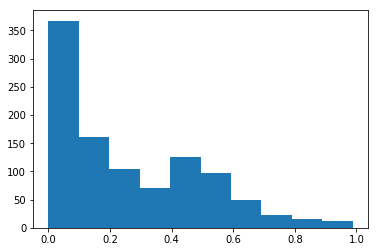

In [17]:
err_red = np.sqrt(np.square(xtest_red[1] - decoded_imgs_red[1]))
plt.hist(err_red)

(array([397., 153., 100.,  68., 118.,  91.,  47.,  19.,  12.,  19.]),
 array([2.9802322e-08, 9.8039240e-02, 1.9607845e-01, 2.9411766e-01,
        3.9215687e-01, 4.9019611e-01, 5.8823532e-01, 6.8627453e-01,
        7.8431374e-01, 8.8235295e-01, 9.8039216e-01], dtype=float32),
 <a list of 10 Patch objects>)

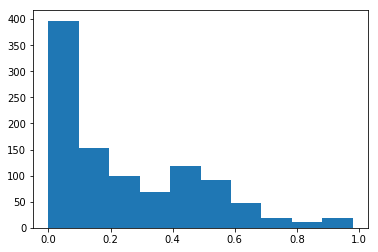

In [18]:
err_green = np.sqrt(np.square(xtest_green[1] - decoded_imgs_green[1]))
plt.hist(err_green)

(array([367., 161., 104.,  70., 126.,  97.,  50.,  22.,  15.,  12.]),
 array([5.9604645e-08, 9.8822385e-02, 1.9764471e-01, 2.9646704e-01,
        3.9528936e-01, 4.9411169e-01, 5.9293401e-01, 6.9175637e-01,
        7.9057866e-01, 8.8940096e-01, 9.8822331e-01], dtype=float32),
 <a list of 10 Patch objects>)

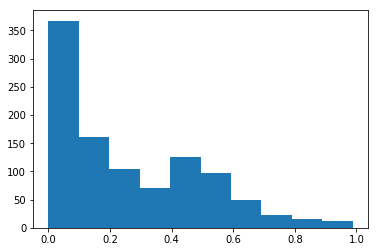

In [19]:
err_blue = np.sqrt(np.square(xtest_blue[1] - decoded_imgs_blue[1]))
plt.hist(err_red)